#### CNN custom MNIST
CNN example for custom MNIST images (instead of TensorFlow native MNIST dataset)

In [1]:
import numpy as np
from PIL import Image
import os
import csv
import tensorflow as tf
# function to read images and labels from a CSV
# CSV format: <relative file path>,<label>
def get_dataset(csv_path):
  images = []
  labels = []
  
  with open(csv_path, 'rb') as csvfile:
    csv_reader = csv.reader(csvfile)
    for rel_path, label in csv_reader:
      # create absolute image path
      #abs_path = os.getcwd() + '/MNIST_data/mnist/' + rel_path
      abs_path = os.getcwd() + "/mnist/" + rel_path
      # read image and reshape from 28x28 to 1x784
      img = np.asarray(Image.open(abs_path)).reshape(1, -1)
      img_f32 = np.float32([x / 255.0 for x in img])
      # append images and labels to lists
      images.append(img_f32)
      labels.append(int(label))
  
  # convert lists into numpy ndarrays and reshape
  images_array = np.asarray(images).reshape(-1, 784)
  labels_array = np.asarray(labels).reshape(1, -1).flatten()
  # one-hot encode labels
  sess = tf.Session()
  with sess.as_default():
    labels_one_hot = tf.one_hot(labels_array, 10).eval()
  
  return images_array, labels_one_hot

train_images, train_labels = get_dataset(os.getcwd() + "/mnist/train-labels.csv")
test_images, test_labels = get_dataset(os.getcwd() + "/mnist/test-labels.csv")

In [4]:
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Weight Initialization
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

#Convolution and Pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and Evaluate
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

In [5]:
import time
start_time = time.time()

for i in range(20000):
   # select a random minibatch (MNIST sample size: 60000, batch size: 100)
  indices = np.random.choice(60000, 100)
  batch_xs, batch_ys = train_images[indices], train_labels[indices]
  if i%500 == 0:
    train_accuracy = accuracy.eval(feed_dict={
      x:batch_xs, y_: batch_ys, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
    
end_time = time.time()

step 0, training accuracy 0.08
step 500, training accuracy 0.9
step 1000, training accuracy 0.99
step 1500, training accuracy 0.97
step 2000, training accuracy 0.99
step 2500, training accuracy 1
step 3000, training accuracy 0.99
step 3500, training accuracy 0.99
step 4000, training accuracy 0.99
step 4500, training accuracy 0.99
step 5000, training accuracy 1
step 5500, training accuracy 1
step 6000, training accuracy 1
step 6500, training accuracy 1
step 7000, training accuracy 0.99
step 7500, training accuracy 0.99
step 8000, training accuracy 1
step 8500, training accuracy 0.99
step 9000, training accuracy 1
step 9500, training accuracy 1
step 10000, training accuracy 1
step 10500, training accuracy 1
step 11000, training accuracy 1
step 11500, training accuracy 1
step 12000, training accuracy 1
step 12500, training accuracy 1
step 13000, training accuracy 1
step 13500, training accuracy 1
step 14000, training accuracy 1
step 14500, training accuracy 1
step 15000, training accuracy

In [6]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: test_images, y_: test_labels, keep_prob: 1.0}))

training_time = end_time - start_time
print "Training time (seconds): ",training_time

test accuracy 0.9927
Training time (seconds):  289.475759029


#### Visualizing Neural Network Layer Activation
https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4#.ksc8aztu9

In [7]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

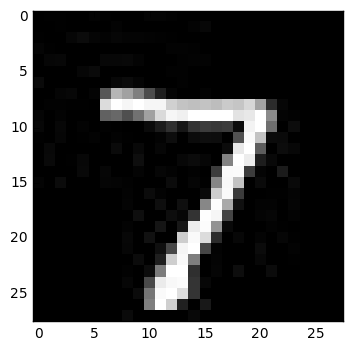

In [9]:
import numpy as np
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt

imageToUse = test_images[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")

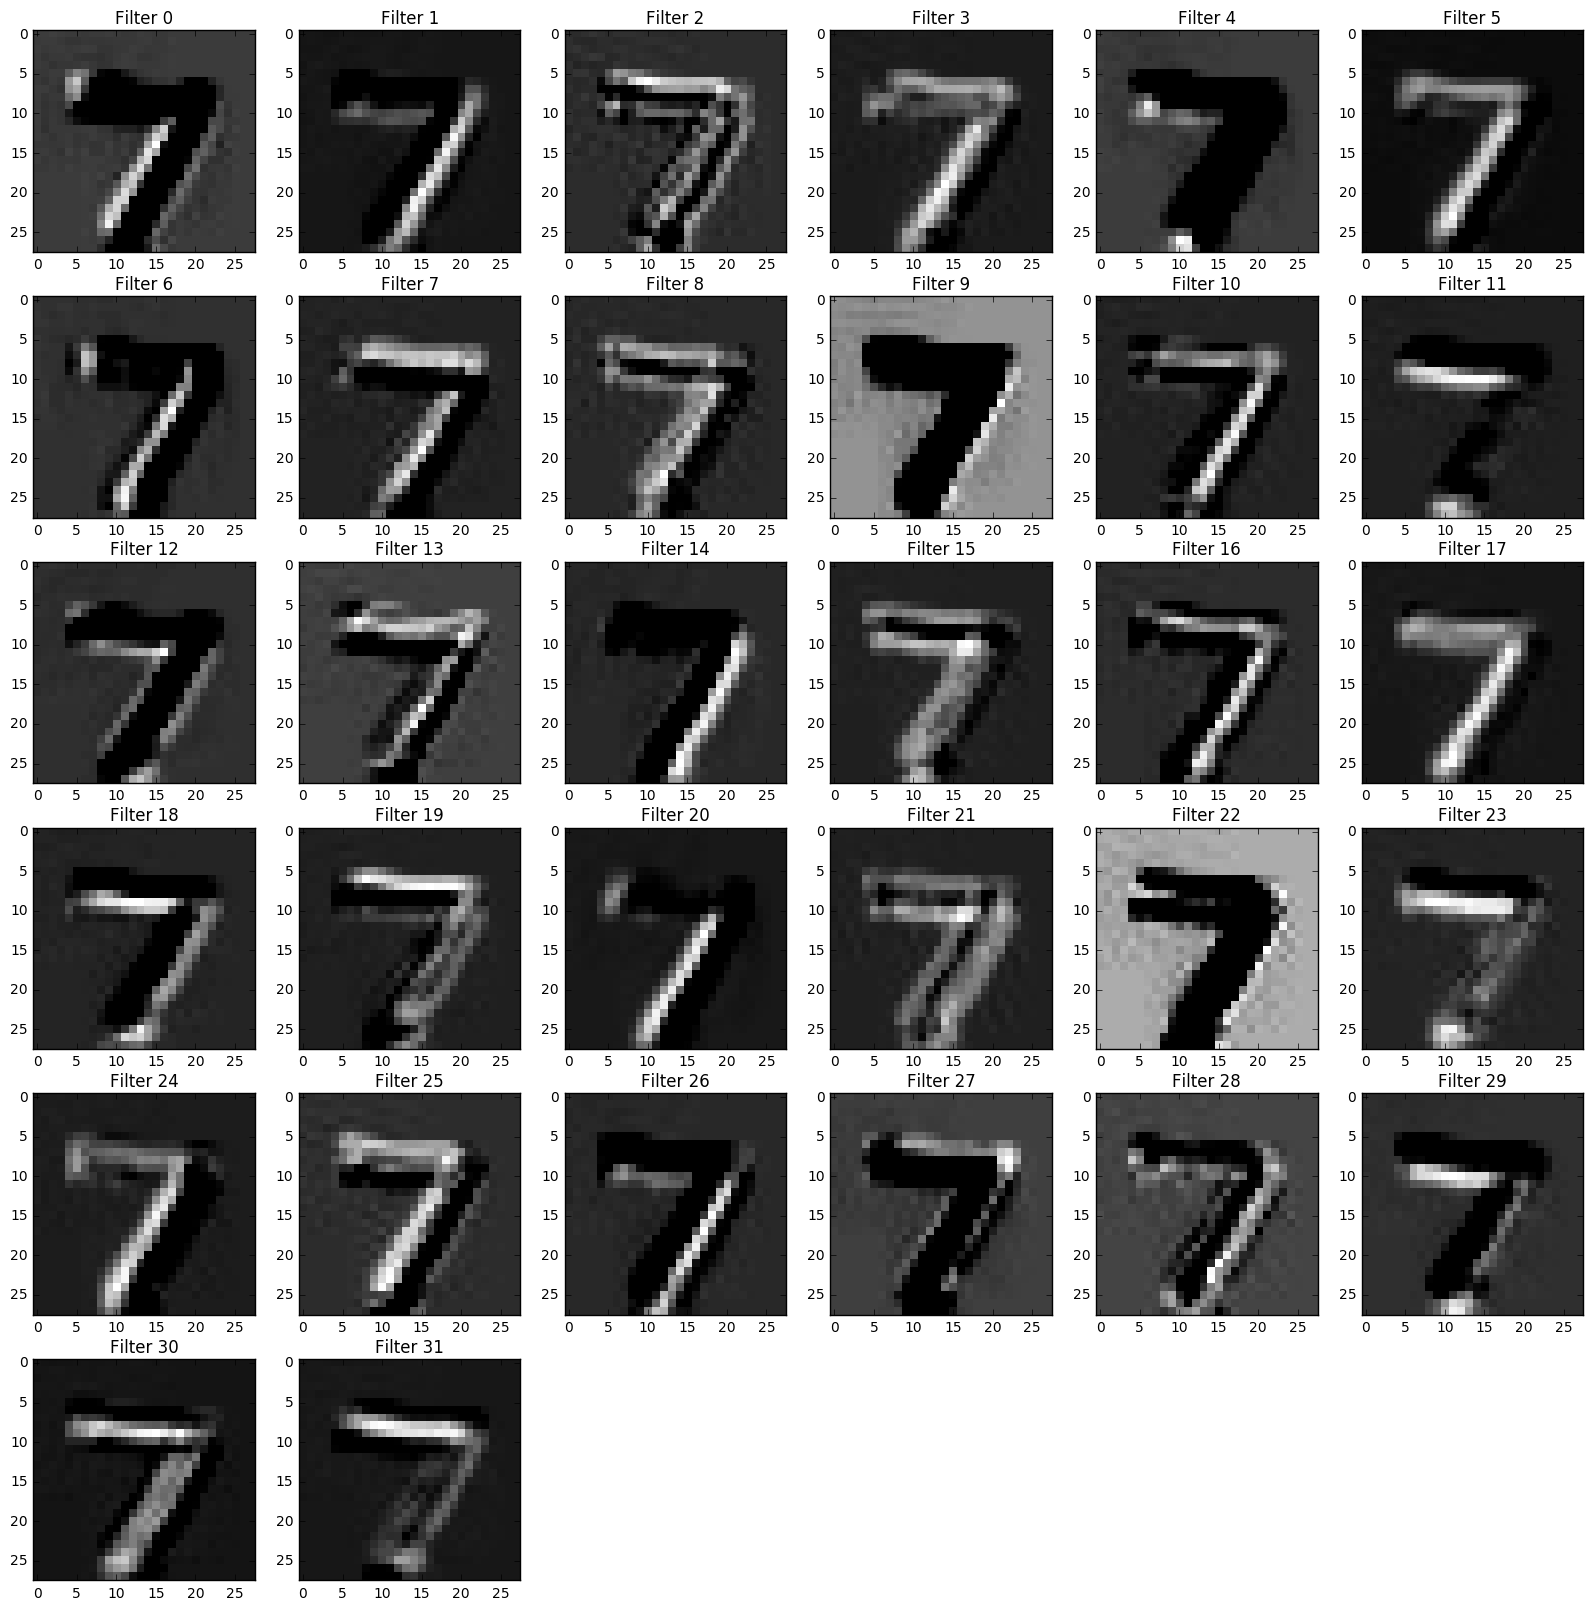

In [10]:
import math

getActivations(h_conv1,imageToUse)

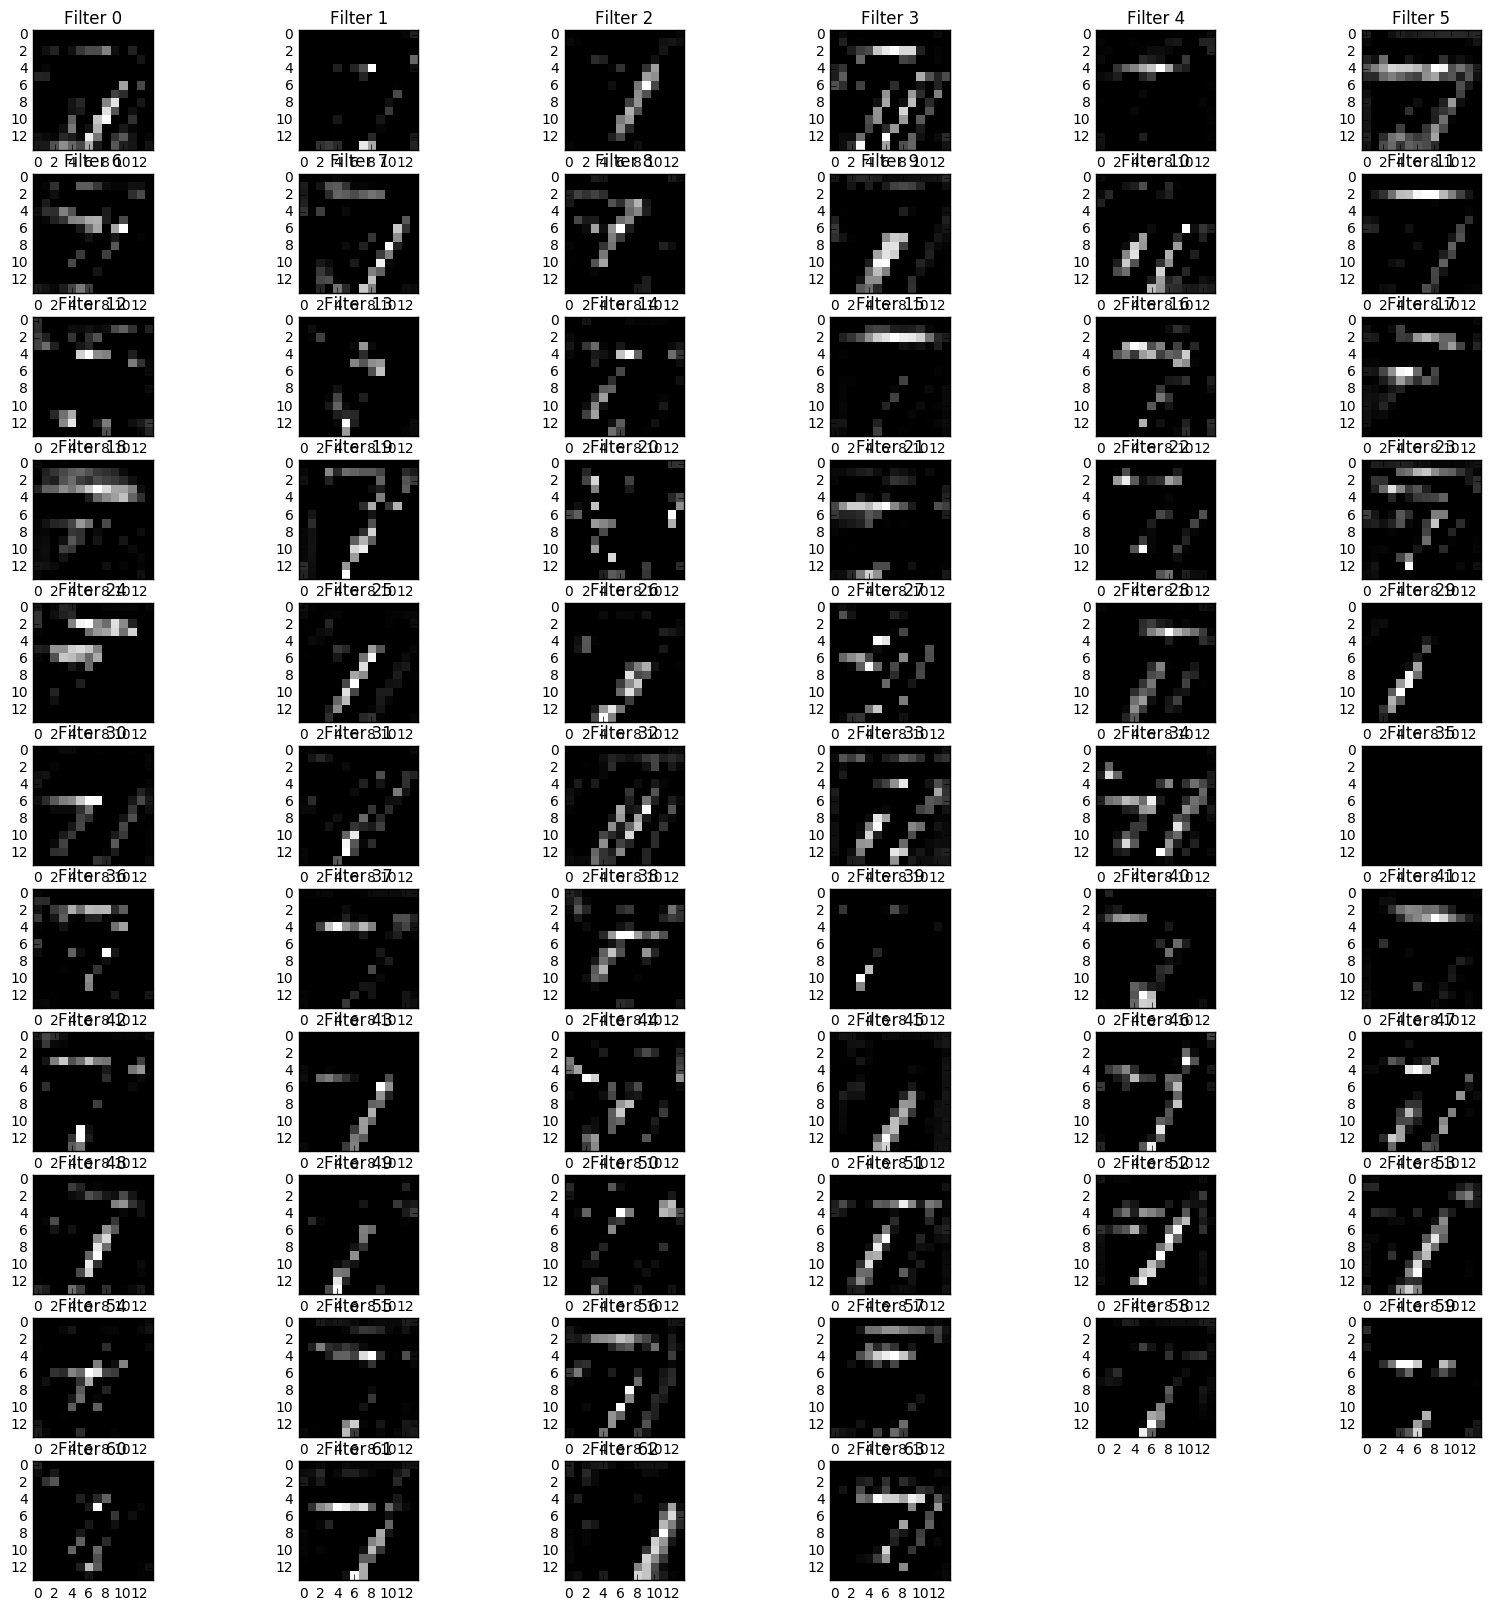

In [11]:
getActivations(h_conv2,imageToUse)